In [7]:
from fastai.vision import *
from fastai.metrics import error_rate
import pandas as pd

In [2]:
# Get Test Set 
# !wget https://www2.seas.gwu.edu/~astylianou/hotels50k/test.tar.gz

# Formatting Data 

In [4]:
t = Path('Hotels-50K/images/train/')

In [29]:
# images/train/chain_id/hotel_id/data_source/image_id.jpg
def extract(limit=False):
    data = []
    i = 0
    for chain_id in t.ls():
        for hotel_id in chain_id.ls():
            for d_source in hotel_id.ls():
                for image_id in d_source.ls():
                    i += 1
                    data.append([chain_id.name, 
                                 hotel_id.name, 
                                 d_source.name, 
                                 image_id.name,
                                 str(image_id)])
                    if limit and i > 200:
                        return data

In [30]:
d = extract(limit=True)

In [42]:
df = pd.DataFrame(d, columns=['chain_id',
                              'hotel_id',
                              'd_source',
                              'image_id',
                              'path'])
df.head()
# df.to_csv(...) save + package for cloud

,chain_id,hotel_id,d_source,image_id,path
0,61,49863,travel_website,1123686.jpg,Hotels-50K/images/train/61/49863/travel_websit...
1,61,49863,travel_website,1123684.jpg,Hotels-50K/images/train/61/49863/travel_websit...
2,61,49863,travel_website,1123685.jpg,Hotels-50K/images/train/61/49863/travel_websit...
3,61,49863,travel_website,1123682.jpg,Hotels-50K/images/train/61/49863/travel_websit...
4,61,49863,travel_website,1123683.jpg,Hotels-50K/images/train/61/49863/travel_websit...


In [44]:
batch_size = 10
img_size = 224
ds_tfms = None
label_col = 1 # hotel_id

data = ImageDataBunch.from_df('.', 
                              df, 
                              label_col=label_col,
                              fn_col=-1, 
                              ds_tfms=ds_tfms, 
                              size=img_size,
                              bs=batch_size)

# View Data

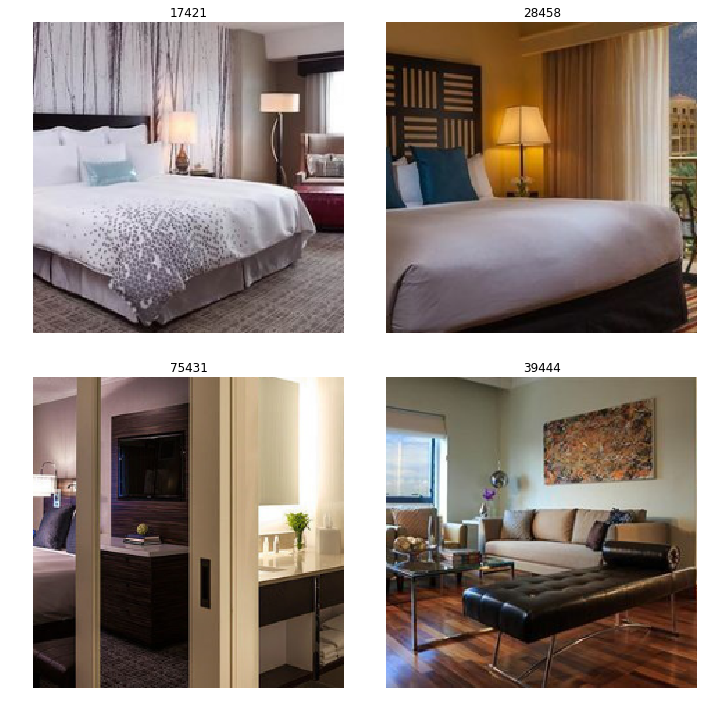

In [45]:
data.show_batch(rows=2, figsize=(10, 10))

In [46]:
# learn = cnn_learner(data, models.resnet34, metrics=error_rate)

In [41]:
# learn.fit_one_cycle(1)